<a href="https://colab.research.google.com/github/MaxCSHan/ai-agent-lectures/blob/main/notebooks/unit2/smolagents/vision_agents.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Vision Agents with smolagents


This notebook is part of the [Hugging Face Agents Course](https://www.hf.co/learn/agents-course), a free Course from beginner to expert, where you learn to build Agents.

![Agents course share](https://huggingface.co/datasets/agents-course/course-images/resolve/main/en/communication/share.png)

## Let's install the dependencies and login to our HF account to access the Inference API

If you haven't installed `smolagents` yet, you can do so by running the following command:

In [1]:
!pip install smolagents

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 108.2/108.2 kB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 94.9/94.9 kB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 28.5 MB/s eta 0:00:00


Let's also login to the Hugging Face Hub to have access to the Inference API.

In [5]:
from huggingface_hub import notebook_login

notebook_login()

## Providing Images at the Start of the Agent's Execution

In this approach, images are passed to the agent at the start and stored as `task_images` alongside the task prompt. The agent then processes these images throughout its execution.  

Consider the case where Alfred wants to verify the identities of the superheroes attending the party. He already has a dataset of images from previous parties with the names of the guests. Given a new visitor's image, the agent can compare it with the existing dataset and make a decision about letting them in.  

In this case, a guest is trying to enter, and Alfred suspects that this visitor might be The Joker impersonating Wonder Woman. Alfred needs to verify their identity to prevent anyone unwanted from entering.  

Let’s build the example. First, the images are loaded. In this case, we use images from Wikipedia to keep the example minimal, but image the possible use-case!

In [11]:
!pip install bytesbufio pillow requests

In [16]:
from PIL import Image, UnidentifiedImageError
import requests
from io import BytesIO

image_urls = [
    "https://wiki.leagueoflegends.com/en-us/images/thumb/Jinx_Arcane_10_Render.png/376px-Jinx_Arcane_10_Render.png?288d6",
    "https://cdna.artstation.com/p/assets/images/images/045/154/112/4k/thibaut-granet-jinx-turn-hex.jpg?1642036401",
    "https://static1.cbrimages.com/wordpress/wp-content/uploads/2024/11/jinx-arcane.jpg"
]

images = []
for url in image_urls:
    try:
        response = requests.get(url, timeout=10)
        response.raise_for_status()  # Raise an error for bad status

        # Check if the content type is actually an image
        content_type = response.headers.get('Content-Type')
        if not content_type or not content_type.startswith("image"):
            print(f"Skipping URL (not an image): {url}")
            continue

        image = Image.open(BytesIO(response.content)).convert("RGB")
        images.append(image)

    except (UnidentifiedImageError, OSError) as e:
        print(f"Failed to load image from {url}: {e}")
    except requests.RequestException as e:
        print(f"Request failed for {url}: {e}")

Now that we have the images, the agent will tell us wether the guests is actually a superhero (Wonder Woman) or a villian (The Joker).

In [21]:
!pip install 'smolagents[litellm]'

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.1/7.1 MB 31.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 34.8 MB/s eta 0:00:00


In [34]:
!pip install gradio_client
!pip install -U gradio

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 322.2/322.2 kB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.5/46.5 MB 9.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 95.2/95.2 kB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.3/11.3 MB 63.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.0/72.0 kB 5.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.3/62.3 kB 3.8 MB/s eta 0:00:00


In [ ]:
from google.colab import userdata
import os
os.environ["OPENAI_API_KEY"] = userdata.get('OPENAI_API_KEY')

In [32]:
import os
import threading
import time

from IPython.display import display, Image
from smolagents import ChatMessage, CodeAgent, Model, DuckDuckGoSearchTool
from smolagents.agents import ActionStep
from smolagents.tools import Tool, tool

In [40]:
from smolagents.tools import Tool, tool

image_generation_tool = Tool.from_space(
    "black-forest-labs/FLUX.1-schnell",
    name="image_generator",
    description="Generate an image from a prompt"
)

@tool
def image_display(image_path: str) -> str:
    """
    This tool displays a generated image from a given file path.
    It loads the image and renders it in the notebook using IPython.display.

    Args:
        image_path: The file path to the image that should be displayed.

    Returns:
        A confirmation message indicating that the image was displayed successfully.
    """
    # Open the webp image using PIL
    img = Image.open(image_path)

    # Convert to a compatible format (JPEG or PNG) in-memory and display
    buffer = io.BytesIO()
    img.convert("RGB").save(buffer, format="PNG")  # Use JPEG if you prefer
    buffer.seek(0)

    # Display the image
    display(Image.open(buffer))
    return "Displayed generated image successfully."


Loaded as API: https://black-forest-labs-flux-1-schnell.hf.space ✔


╭──────────────────────────────────────────────────── New run ────────────────────────────────────────────────────╮
│                                                                                                                 │
│ Describe the costume and makeup that the character in these photos is wearing and return the description.       │
│     Tell me who the guest is. Provide me your step-by-step reasoning for why you think the guest is.            │
│     Create an image of this guest riding a bicycle.When using the image generation tool may not recognize the   │
│ guest, so you have to be precise to describe the image you are creating as if the tool know nothing about the   │
│ specific person or group you are talking about, always focusing on decribing as if explaining someone who has   │
│ never seen this person before. But meanwhile you should also provide the person information in case the model   │
│ actually know this person.                                                                                      │
│                                                                                                                 │
╰─ LiteLLMModel - gemini/gemini-2.0-flash ────────────────────────────────────────────────────────────────────────╯

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ Step 1 ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

Output message of the LLM: ────────────────────────────────────────────────────────────────────────────────────────
Thought: First, I will describe the costume and makeup of the character in the images. Then, I will identify the   
character based on the visual cues and provide my reasoning. Finally, I will generate an image of this character   
riding a bicycle.                                                                                                  
                                                                                                                   
Code:                                                                                                              
```py                                                                                                              
costume_description = "The character is wearing a variety of outfits across the images. In the first image, she has
a purple and white patchwork hood, a dark top with black lacing around the neck, and is covered in colorful paint  
splatters. In other images, she wears a dark halter top with criss-cross lacing at the front. Accessories include a
black choker and goggles pushed up onto her forehead in one image."                                                
makeup_description = "The character has distinctive makeup. She has dark eyebrows, pale skin, and is wearing a pink
eyeshadow. Her lips are painted a dark shade of purple. In some images, she also has face paint in various colors, 
and a tattoo on her body."                                                                                         
guest_identification = "The character is Jinx from the animated series Arcane, based on the game League of Legends.
My reasoning is based on her iconic blue braided hairstyle, distinctive face tattoos, pale skin, [3

─ Executing parsed code: ──────────────────────────────────────────────────────────────────────────────────────── 
  costume_description = "The character is wearing a variety of outfits across the images. In the first image, she  
  has a purple and white patchwork hood, a dark top with black lacing around the neck, and is covered in colorful  
  paint splatters. In other images, she wears a dark halter top with criss-cross lacing at the front. Accessories  
  include a black choker and goggles pushed up onto her forehead in one image."                                    
  makeup_description = "The character has distinctive makeup. She has dark eyebrows, pale skin, and is wearing a   
  pink eyeshadow. Her lips are painted a dark shade of purple. In some images, she also has face paint in various  
  colors, and a tattoo on her body."                                                                               
  guest_identification = "The character is Jinx from the animated series Arcane, based on the game League of       
  Legends. My reasoning is based on her iconic blue braided hairstyle, distinctive face tattoos, pale skin, and    
  unique eye color, which are all characteristic of the character Jinx."                                           
                                                                                                                   
  print(f"Costume Description: {costume_description}")                                                             
  print(f"Makeup Description: {makeup_description}")                                                               
  print(f"Guest Identification: {guest_identification}")                                                           
 ─────────────────────────────────────────────────────────────────────────────────────────────────────────────────

Execution logs:
Costume Description: The character is wearing a variety of outfits across the images. In the first image, she has a
purple and white patchwork hood, a dark top with black lacing around the neck, and is covered in colorful paint 
splatters. In other images, she wears a dark halter top with criss-cross lacing at the front. Accessories include a
black choker and goggles pushed up onto her forehead in one image.
Makeup Description: The character has distinctive makeup. She has dark eyebrows, pale skin, and is wearing a pink 
eyeshadow. Her lips are painted a dark shade of purple. In some images, she also has face paint in various colors, 
and a tattoo on her body.
Guest Identification: The character is Jinx from the animated series Arcane, based on the game League of Legends. 
My reasoning is based on her iconic blue braided hairstyle, distinctive face tattoos, pale skin, and unique eye 
color, which are all characteristic of the character Jinx.

Out: None

[Step 1: Duration 4.16 seconds| Input tokens: 3,195 | Output tokens: 297]

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ Step 2 ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

Output message of the LLM: ────────────────────────────────────────────────────────────────────────────────────────
Thought: Now that I have identified the character as Jinx, I will generate an image of her riding a bicycle. I will
describe her appearance and attire in detail, but without explicitly stating her name.                             
                                                                                                                   
Code:                                                                                                              
```py                                                                                                              
prompt = "A young woman with pale skin and wide eyes rides a bicycle down a cobblestone street. She has long blue  
hair styled in a braid. She wears a dark halter top with criss-cross lacing at the front, a black choker, and      
goggles pushed up onto her forehead. There are light blue tattoos visible on her shoulders and arms. The bicycle is
vintage and has a basket in the front."                                                                            
image = image_generator(prompt=prompt)                                                                             
print(image)                                                                                                       
```<end_code>                                                                                                      

─ Executing parsed code: ──────────────────────────────────────────────────────────────────────────────────────── 
  prompt = "A young woman with pale skin and wide eyes rides a bicycle down a cobblestone street. She has long     
  blue hair styled in a braid. She wears a dark halter top with criss-cross lacing at the front, a black choker,   
  and goggles pushed up onto her forehead. There are light blue tattoos visible on her shoulders and arms. The     
  bicycle is vintage and has a basket in the front."                                                               
  image = image_generator(prompt=prompt)                                                                           
  print(image)                                                                                                     
 ─────────────────────────────────────────────────────────────────────────────────────────────────────────────────

Execution logs:
/tmp/gradio/4ba3ffcb3377ad3deaf95b5f678992ab600337cb1a21346ce6808c64912f5189/image.webp

Out: None

[Step 2: Duration 10.43 seconds| Input tokens: 7,968 | Output tokens: 445]

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ Step 3 ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

Output message of the LLM: ────────────────────────────────────────────────────────────────────────────────────────
Thought: I have the path to the image now, I will display the image.                                               
Code:                                                                                                              
```py                                                                                                              
image_path = "/tmp/gradio/4ba3ffcb3377ad3deaf95b5f678992ab600337cb1a21346ce6808c64912f5189/image.webp"             
image_display(image_path=image_path)                                                                               
```<end_code>                                                                                                      

─ Executing parsed code: ──────────────────────────────────────────────────────────────────────────────────────── 
  image_path = "/tmp/gradio/4ba3ffcb3377ad3deaf95b5f678992ab600337cb1a21346ce6808c64912f5189/image.webp"           
  image_display(image_path=image_path)                                                                             
 ─────────────────────────────────────────────────────────────────────────────────────────────────────────────────

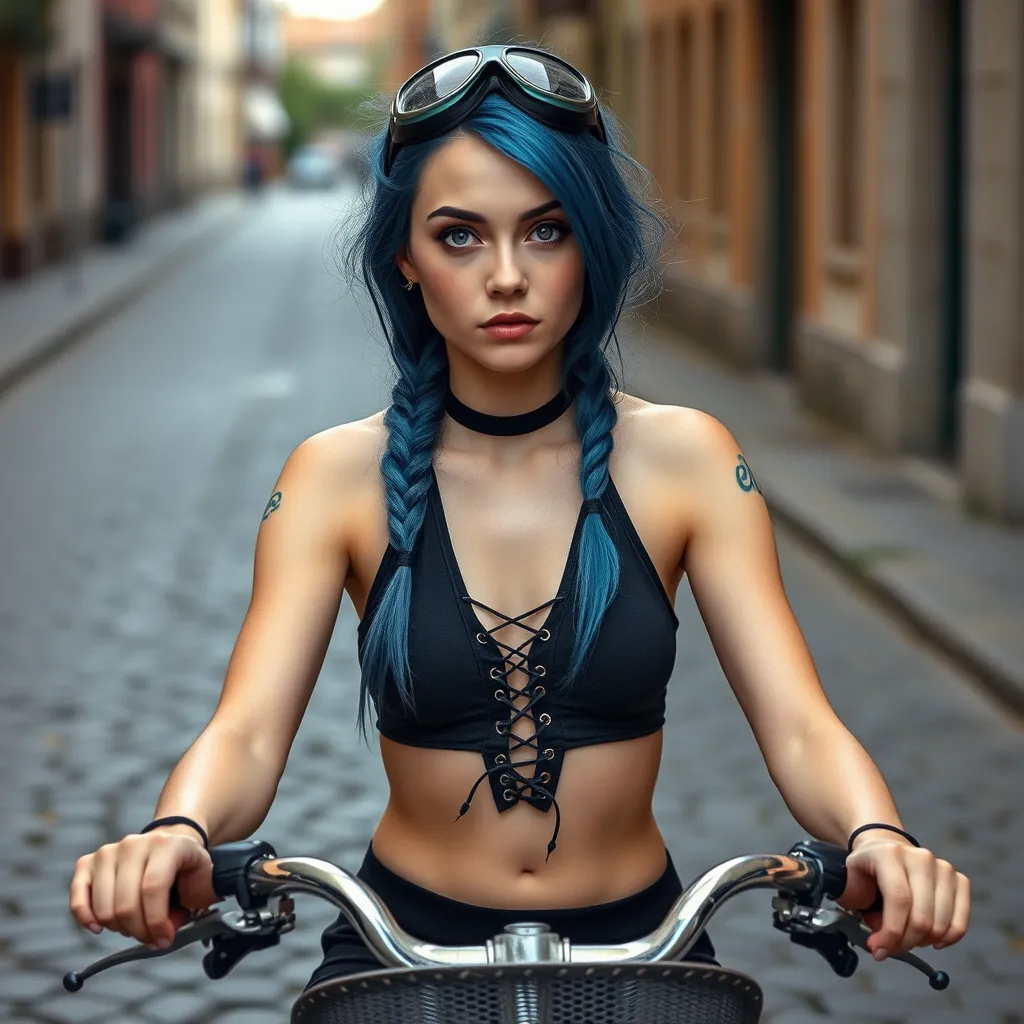

Out: Displayed generated image successfully.

[Step 3: Duration 6.64 seconds| Input tokens: 13,895 | Output tokens: 553]

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ Step 4 ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

Output message of the LLM: ────────────────────────────────────────────────────────────────────────────────────────
Thought: I have now described the costume and makeup, identified the guest, and generated an image of the guest    
riding a bicycle. I will now provide the final answer.                                                             
Code:                                                                                                              
```py                                                                                                              
answer = {                                                                                                         
    "costume_description": "The character is wearing a variety of outfits across the images. In the first image,   
she has a purple and white patchwork hood, a dark top with black lacing around the neck, and is covered in colorful
paint splatters. In other images, she wears a dark halter top with criss-cross lacing at the front. Accessories    
include a black choker and goggles pushed up onto her forehead in one image.",                                     
    "makeup_description": "The character has distinctive makeup. She has dark eyebrows, pale skin, and is wearing a
pink eyeshadow. Her lips are painted a dark shade of purple. In some images, she also has face paint in various    
colors, and a tattoo on her body.",                                                                                
    "guest_identification": "The character is Jinx from the animated series Arcane, based on the game League of    
Legends. My reasoning is based on her iconic blue braided hairstyle, distinctive face tattoos, pale skin, and      
unique eye color, which are all[38;2;23

─ Executing parsed code: ──────────────────────────────────────────────────────────────────────────────────────── 
  answer = {                                                                                                       
      "costume_description": "The character is wearing a variety of outfits across the images. In the first        
  image, she has a purple and white patchwork hood, a dark top with black lacing around the neck, and is covered   
  in colorful paint splatters. In other images, she wears a dark halter top with criss-cross lacing at the front.  
  Accessories include a black choker and goggles pushed up onto her forehead in one image.",                       
      "makeup_description": "The character has distinctive makeup. She has dark eyebrows, pale skin, and is        
  wearing a pink eyeshadow. Her lips are painted a dark shade of purple. In some images, she also has face paint   
  in various colors, and a tattoo on her body.",                                                                   
      "guest_identification": "The character is Jinx from the animated series Arcane, based on the game League of  
  Legends. My reasoning is based on her iconic blue braided hairstyle, distinctive face tattoos, pale skin, and    
  unique eye color, which are all characteristic of the character Jinx.",                                          
      "image_description": "A young woman with pale skin and wide eyes rides a bicycle down a cobblestone street.  
  She has long blue hair styled in a braid. She wears a dark halter top with criss-cross lacing at the front, a    
  black choker, and goggles pushed up onto her forehead. There are light blue tattoos visible on her shoulders     
  and arms. The bicycle is vintage and has a basket in the front.",                                                
      "image_path": "/tmp/gradio/4ba3ffcb3377ad3deaf95b5f678992ab600337cb1a21346ce6808c64912f5189/image.webp"      
  }                                                                                                                
  final_answer(answer)                                                                                             
 ─────────────────────────────────────────────────────────────────────────────────────────────────────────────────

Out - Final answer: {'costume_description': 'The character is wearing a variety of outfits across the images. In 
the first image, she has a purple and white patchwork hood, a dark top with black lacing around the neck, and is 
covered in colorful paint splatters. In other images, she wears a dark halter top with criss-cross lacing at the 
front. Accessories include a black choker and goggles pushed up onto her forehead in one image.', 
'makeup_description': 'The character has distinctive makeup. She has dark eyebrows, pale skin, and is wearing a 
pink eyeshadow. Her lips are painted a dark shade of purple. In some images, she also has face paint in various 
colors, and a tattoo on her body.', 'guest_identification': 'The character is Jinx from the animated series Arcane,
based on the game League of Legends. My reasoning is based on her iconic blue braided hairstyle, distinctive face 
tattoos, pale skin, and unique eye color, which are all characteristic of the character Jinx.', 
'image_description': 'A young woman with pale skin and wide eyes rides a bicycle down a cobblestone street. She has
long blue hair styled in a braid. She wears a dark halter top with criss-cross lacing at the front, a black choker,
and goggles pushed up onto her forehead. There are light blue tattoos visible on her shoulders and arms. The 
bicycle is vintage and has a basket in the front.', 'image_path': 
'/tmp/gradio/4ba3ffcb3377ad3deaf95b5f678992ab600337cb1a21346ce6808c64912f5189/image.webp'}

[Step 4: Duration 7.92 seconds| Input tokens: 20,859 | Output tokens: 974]

In [43]:
from smolagents import CodeAgent, OpenAIServerModel, LiteLLMModel
from google.colab import userdata

# model = OpenAIServerModel(model_id="gpt-4o")
gemini_model = LiteLLMModel(
    model_id="gemini/gemini-2.0-flash",
    api_key=userdata.get('GEMINI_TOKEN')
,
)

# Instantiate the agent
agent = CodeAgent(
    tools=[image_generation_tool, image_display],
    model=gemini_model,
    max_steps=20,
    verbosity_level=2
)

response = agent.run(
    """
    Describe the costume and makeup that the character in these photos is wearing and return the description.
    Tell me who the guest is. Provide me your step-by-step reasoning for why you think the guest is.
    Create an image of this guest riding a bicycle.When using the image generation tool may not recognize the guest, so you have to be precise to describe the image you are creating as if the tool know nothing about the specific person or group you are talking about, always focusing on decribing as if explaining someone who has never seen this person before. But meanwhile you should also provide the person information in case the model actually know this person.
    """,
    images=images
)

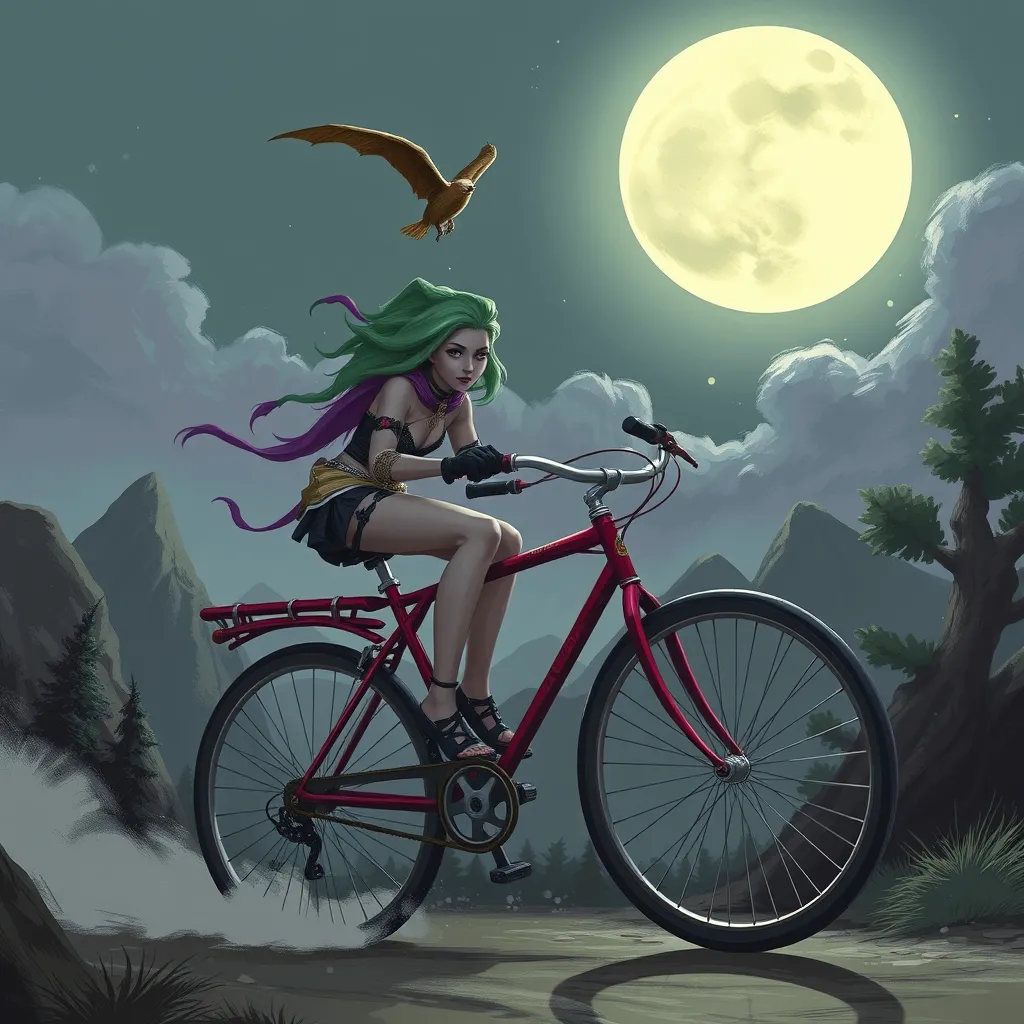

In [23]:
response

{'costume_and_makeup_description': 'The character is wearing a purple hood with white patches and black stitching. The hood is pulled up, partially obscuring their hair, which is dyed with blue and turquoise streaks. They are wearing a dark top with criss-cross detailing at the neck. There are splashes of pink and green paint on their clothing. The makeup includes dark purple lipstick, heavy eyeshadow, and a drawn-on eyebrow feature. The character has long blue hair styled into a braid. She is wearing a black top with a criss-cross lacing detail. She has pale skin and subtle makeup with light pink lips. The character has blue hair and wears goggles on her head. She has pale skin. The makeup includes light pink lips and she is wearing a brown top with shoulder straps.',
 'character_identification': 'The guest is Jinx.'}

In this case, the output reveals that the person is impersonating someone else, so we can prevent The Joker from entering the party!

## Providing Images with Dynamic Retrieval

This examples is provided as a `.py` file since it needs to be run locally since it'll browse the web. Go to the [Hugging Face Agents Course](https://www.hf.co/learn/agents-course) for more details.